In [2]:
import numpy as np
from numpy.linalg import inv
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
def sample_jester_data(file_name, context_dim = 32, num_actions = 8, num_contexts = 19181,
                       shuffle_rows=True, shuffle_cols=False):
        """Samples bandit game from (user, joke) dense subset of Jester dataset.
        
        Args:
            file_name: Route of file containing the modified Jester dataset.
            context_dim: Context dimension (i.e. vector with some ratings from a user).
            num_actions: Number of actions (number of joke ratings to predict).
            num_contexts: Number of contexts to sample.
            shuffle_rows: If True, rows from original dataset are shuffled.
            shuffle_cols: Whether or not context/action jokes are randomly shuffled.
            
        Returns:
            dataset: Sampled matrix with rows: (context, rating_1, ..., rating_k).
            opt_vals: Vector of deterministic optimal (reward, action) for each context.
        """
        np.random.seed(0)
        with tf.gfile.Open(file_name, 'rb') as f:
            dataset = np.load(f)
            
        if shuffle_cols:
            dataset = dataset[:, np.random.permutation(dataset.shape[1])]
        if shuffle_rows:
            np.random.shuffle(dataset)
        dataset = dataset[:num_contexts, :]
            
        assert context_dim + num_actions == dataset.shape[1], 'Wrong data dimensions.'
        
        opt_actions = np.argmax(dataset[:, context_dim:], axis=1)
        opt_rewards = np.array([dataset[i, context_dim + a] for i, a in enumerate(opt_actions)])
        
        return dataset, opt_rewards, opt_actions

In [4]:
def choose_arm(decay_rate, decay_step, predictions):
    # Choose an action from state s by using epsilon greedy
    explore_start = 1.0
    explore_stop = 0.01
    explore_exploit_tradeoff = np.random.rand()
    explore_probability = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * decay_step)

    if (explore_probability > explore_exploit_tradeoff):
        # Select a random arm 
        arm_selection = random.choice(range(len(predictions)))
    else:
        # Select from arms with the highest expected reward
        max_arms = np.amax(predictions)
        indices = np.nonzero(predictions == max_arms)[0]
        arm_selection = random.choice(indices)

    return arm_selection

## Read data

In [5]:
dataset, opt_rewards, opt_actions = sample_jester_data('jester_data_40jokes_19181users.npy')

## Set parameters

In [6]:
alpha = 1.25
context_cols = 32
reward_cols = 8
n_trials = 18000 
arms = 8

In [7]:
A = np.zeros((arms, context_cols, context_cols)) 
reward = np.zeros((arms, context_cols))
theta = np.zeros((arms, context_cols))

for arm in range(arms):
    A[arm] = np.identity(context_cols)

## Train

In [8]:
earned_rewards = []
for trial in range(n_trials):
    context = dataset[trial][:context_cols] 
    gt_rewards = dataset[trial][-reward_cols:]
    predictions = []
    for arm in range(arms):
        A_inv = inv(A[arm])
        theta[arm] = np.matmul(A_inv, reward[arm])
        p_ta = np.matmul(theta[arm].transpose(), context) + alpha * np.sqrt(np.matmul(np.matmul(context.transpose(), A_inv), context))
        predictions.append(p_ta)
    
    arm_selection = choose_arm(0.001, trial, predictions)
    A[arm_selection] = A[arm_selection] + np.matmul(context, context.transpose())
    reward[arm_selection] = reward[arm_selection] + gt_rewards[arm_selection] * context
    earned_rewards.append(gt_rewards[arm_selection])

## Test

In [9]:
test_regrets = []
for trial in range(n_trials, len(dataset)):
    context = dataset[trial][:context_cols] 
    gt_rewards = dataset[trial][-reward_cols:]
    predictions = []
    for arm in range(arms):
        A_inv = inv(A[arm])
        theta[arm] = np.matmul(A_inv, reward[arm])
        p_ta = np.matmul(theta[arm].transpose(), context) + alpha * np.sqrt(np.matmul(np.matmul(context.transpose(), A_inv), context))
        predictions.append(p_ta)
    arm_selection = choose_arm(0.01, n_trials, predictions)
    regret = np.max(gt_rewards) - gt_rewards[arm_selection]
    test_regrets.append(regret)

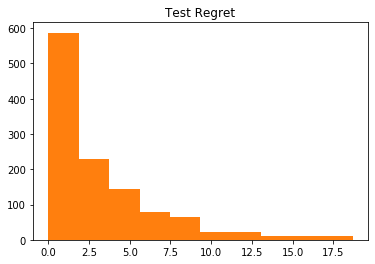

In [11]:
plt.hist(test_regrets)
plt.title("Test Regret")
plt.show()